# WIT oil value over time

## Modules

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import convolve, fftconvolve
from statsmodels.graphics.tsaplots import plot_acf

## Relevant functions

In [39]:
def DummiePulse(i,n):
    ls=[0 for x in range(n)]
    ls[i]= 1
    return ls
def DummieLevel(i,n):
    ls=[1 if x>i else 0 for x in range(n) ]
    return ls
def DummieTendency(i,n):
    ls=[0 if x<=i else x-i for x in range(n)]
    return ls
def DummieTendencyCentral(i,n):
    ls=[0 for x in range(n)]

In [110]:
def box_ljung(ls_best, df_filters):    
    df_box= pd.DataFrame(columns=["Model", "lb_stat", "lb_pvalue"])
    for model in ls_best:
        lags = 50
        test_results = sm.stats.acorr_ljungbox(df_filters[model], lags=lags, boxpierce=False, return_df=True)

        # Print test results
        test_results["Model"]= model
        df_box= pd.concat([df_box, test_results], ignore_index=True)
        
    return df_box

## Load data

In [2]:
data= pd.read_csv("WTI.csv")
data.rename(columns={"Cierre":'Value', "Fecha": "Date"}, inplace=True)
data.drop(columns=data.columns[2:], inplace=True)

In [3]:
data.set_index("Date",inplace=True)

In [4]:
data.head()

,Value
Date,
01/09/2022,82.56
02/09/2022,83.09
03/09/2022,83.09
04/09/2022,83.15
05/09/2022,83.15


## Preprossesing

In [68]:
df= data.copy()

### Log transformation

In [69]:
df["LogValue"]= df["Value"].apply(lambda x: np.log(x))

In [70]:
df["AuxDate"]= df.index
df["Ind"]= [x for x in range(len(df))]

### Visualization

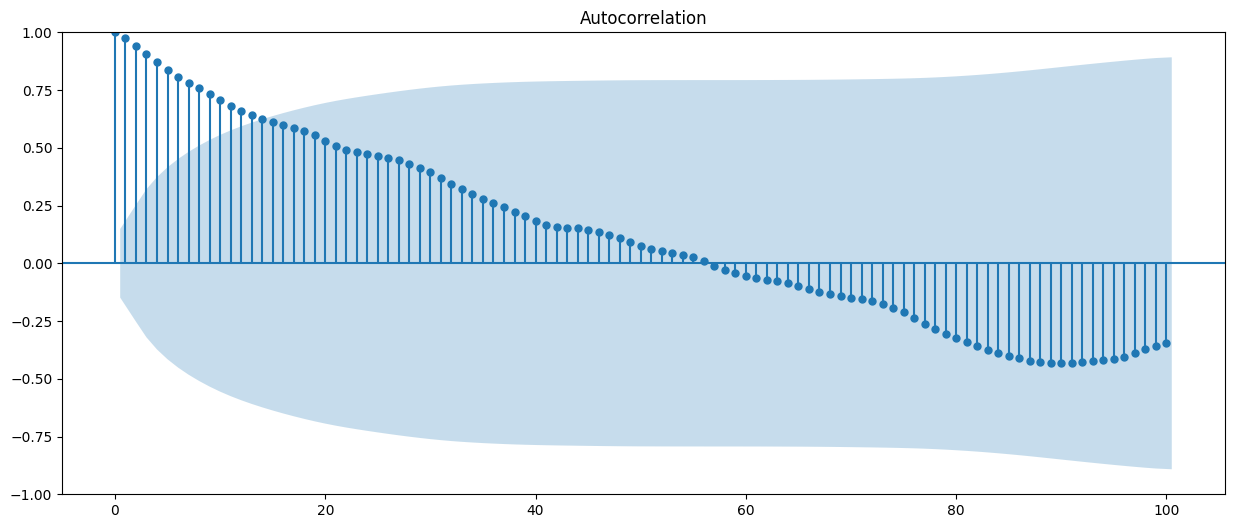

In [18]:
fig=plot_acf(df["LogValue"], lags=100)
fig.set_size_inches(15, 6)
plt.show()

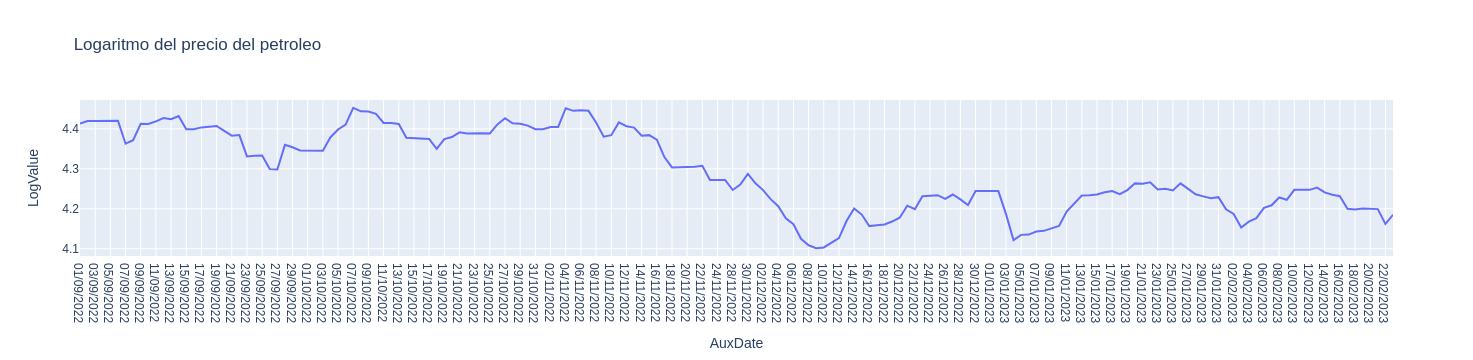

In [28]:
fig = px.line(df, x="AuxDate", y="LogValue", title='Logaritmo del precio del petroleo',
             hover_data= ['AuxDate','Ind'] )

fig.show()

### Create dummies

In [29]:
n= len(df)

#### Level

### Tendency

In [71]:
df["Sep27T"]= DummieTendency(26,n)

### Add time

In [72]:
df["t"]= [x+1 for x in range(n)]
df["t2"]= df["t"]**2
df["t3"]= df["t"]**3

In [73]:
df.iloc[20:30,:]

,Value,LogValue,AuxDate,Ind,Sep27T,t,t2,t3
Date,,,,,,,,
21/09/2022,80.08,4.383026,21/09/2022,20,0,21,441,9261
22/09/2022,80.20,4.384524,22/09/2022,21,0,22,484,10648
23/09/2022,76.03,4.331128,23/09/2022,22,0,23,529,12167
24/09/2022,76.15,4.332705,24/09/2022,23,0,24,576,13824
25/09/2022,76.19,4.333230,25/09/2022,24,0,25,625,15625
26/09/2022,73.66,4.299460,26/09/2022,25,0,26,676,17576
27/09/2022,73.58,4.298373,27/09/2022,26,0,27,729,19683
28/09/2022,78.26,4.360037,28/09/2022,27,1,28,784,21952
29/09/2022,77.79,4.354013,29/09/2022,28,2,29,841,24389


## Tendency Model

In [81]:
dc_grade={1:-2, 2:-1, 3: n}

In [82]:
for i in range(1,4):
    ls_var= df.columns[4:dc_grade[i]]
    X= df[ls_var].copy()
    y= df["LogValue"].copy()
    X = sm.add_constant(X)
    model= sm.OLS(y,X).fit()
    df["Tendency"+str(i)]=model.predict(X)
    df["W"+str(i)]= df["LogValue"]-df["Tendency"+str(i)]

In [84]:
df.sample(5)

,Value,LogValue,AuxDate,Ind,Sep27T,t,t2,t3,Tendency1,W1,Tendency2,W2,Tendency3,W3
Date,,,,,,,,,,,,,,
16/10/2022,79.50,4.375757,16/10/2022,45,19,46,2116,97336,4.362638,0.013119,4.387151,-0.011394,4.375757,1.979750e-12
17/02/2023,66.68,4.199905,17/02/2023,167,141,168,28224,4741632,4.166871,0.033034,4.243114,-0.043209,4.199905,9.831869e-11
02/12/2022,69.88,4.246779,02/12/2022,90,64,91,8281,753571,4.290429,-0.043649,4.279896,-0.033116,4.246779,1.555378e-11
21/12/2022,67.21,4.207822,21/12/2022,109,83,110,12100,1331000,4.259941,-0.052118,4.222159,-0.014337,4.207822,2.752376e-11
26/09/2022,73.66,4.299460,26/09/2022,25,0,26,676,17576,4.393920,-0.094460,4.378583,-0.079123,4.299460,3.437250e-13


In [91]:
aux= pd.melt(df,id_vars=['AuxDate'],value_vars=[ "LogValue","Tendency1", "W1","Tendency2", "W2","Tendency3", "W3"] )

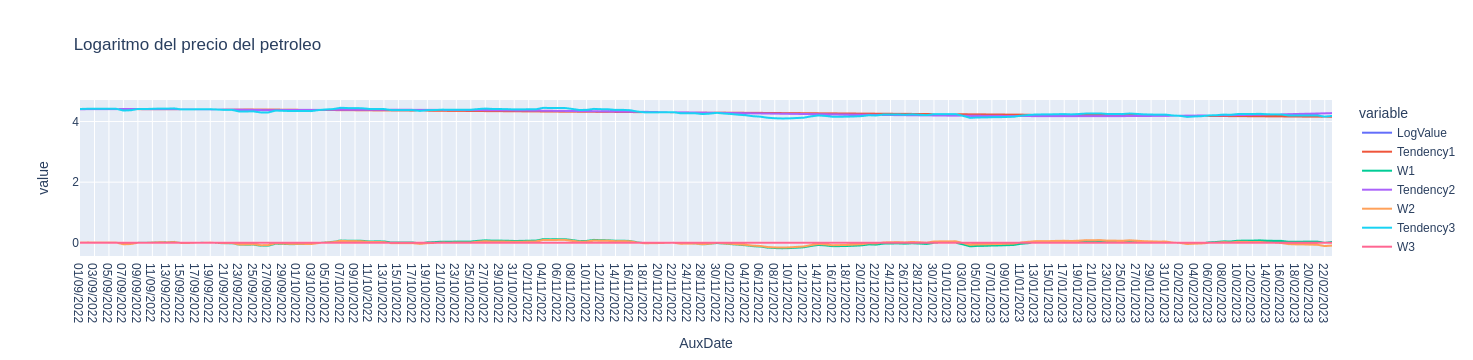

In [92]:
fig = px.line(aux, x="AuxDate", y="value", color="variable",title='Logaritmo del precio del petroleo' )

fig.show()

## Filters

In [101]:
df_filters= df[["AuxDate", "W1", "W2", "W3"]].copy()

Para el modelo W1--------------------------------------------------------
-------------Convulucion W1 1/2 


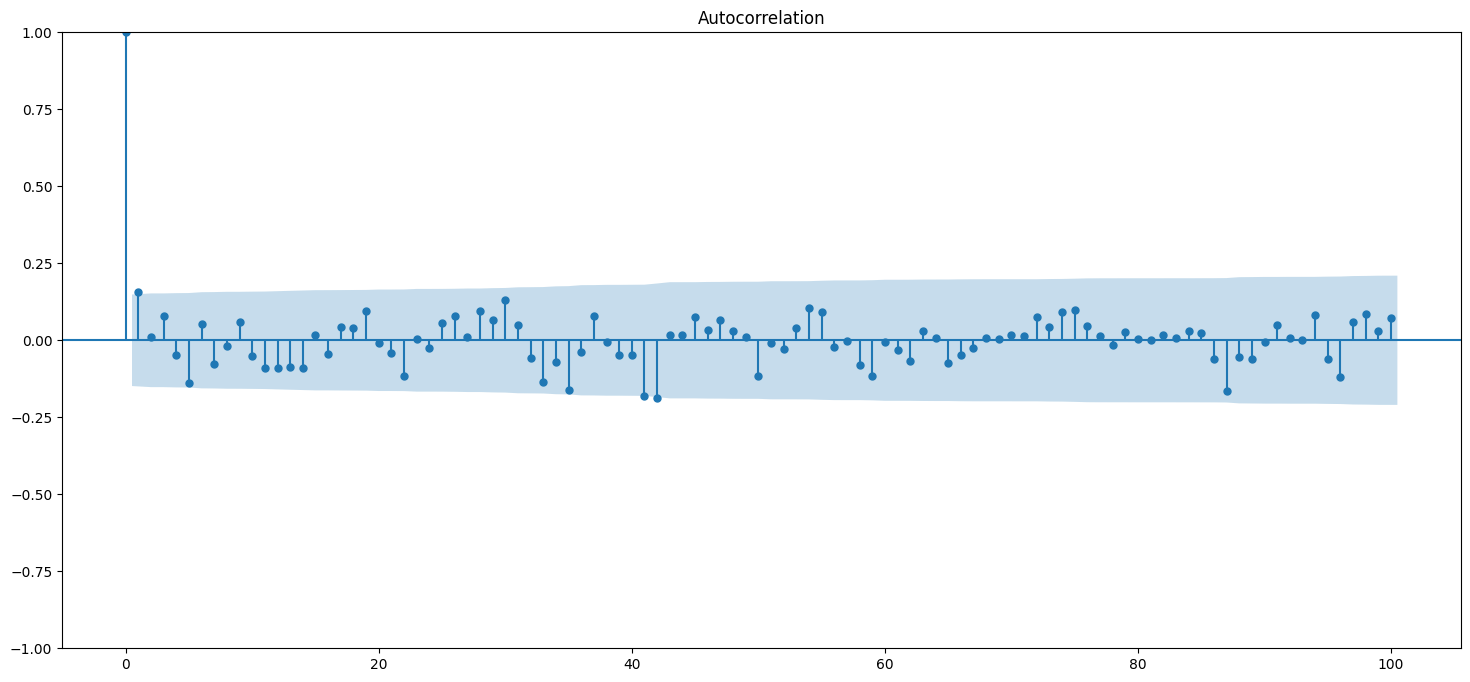

-------------Convulucion W1 1/3 


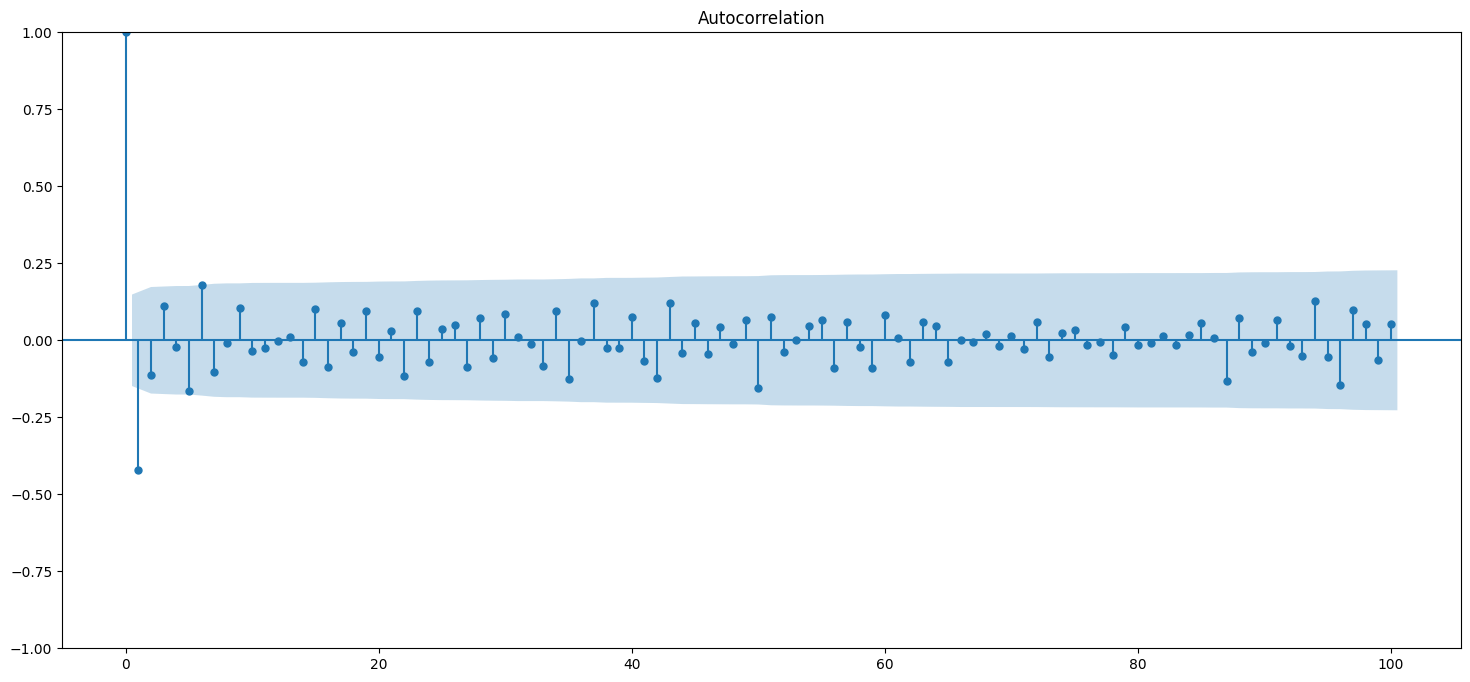

-------------Convulucion W1 1/4 


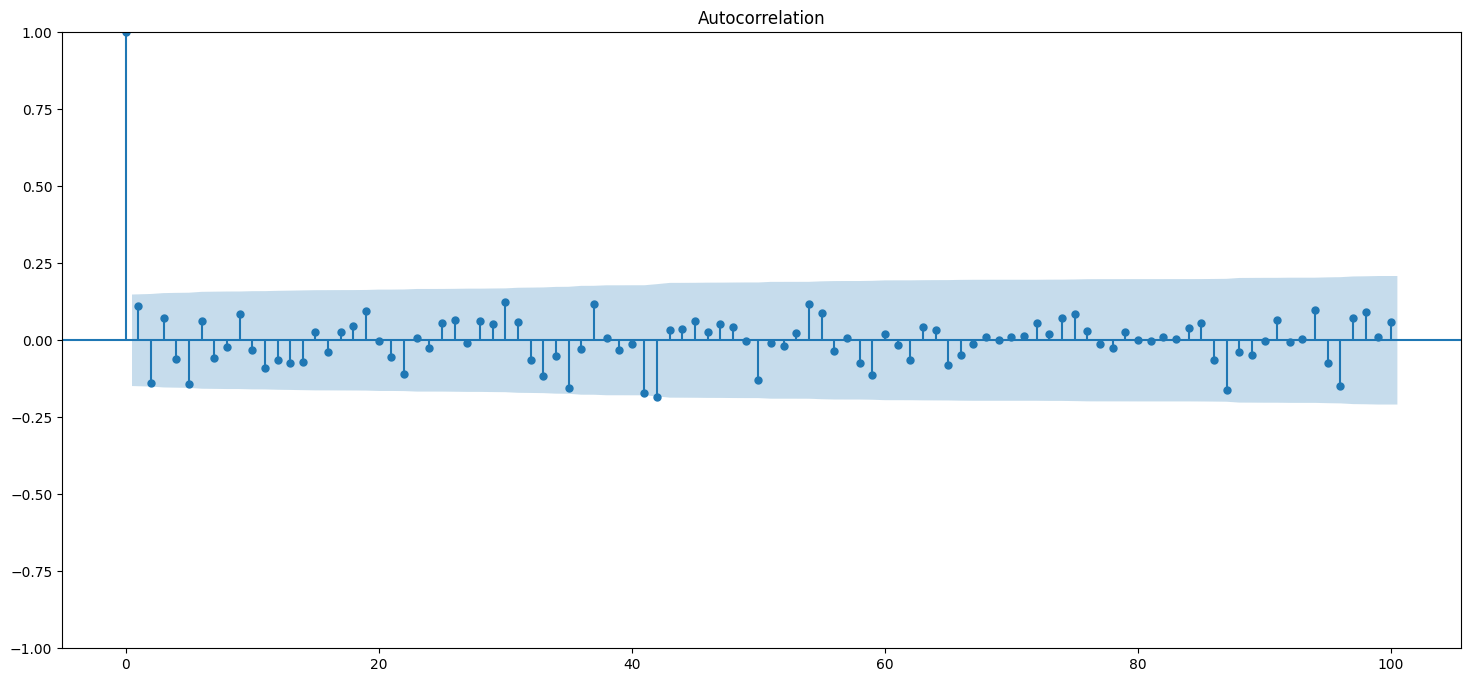

-------------Convulucion W1 1/5 


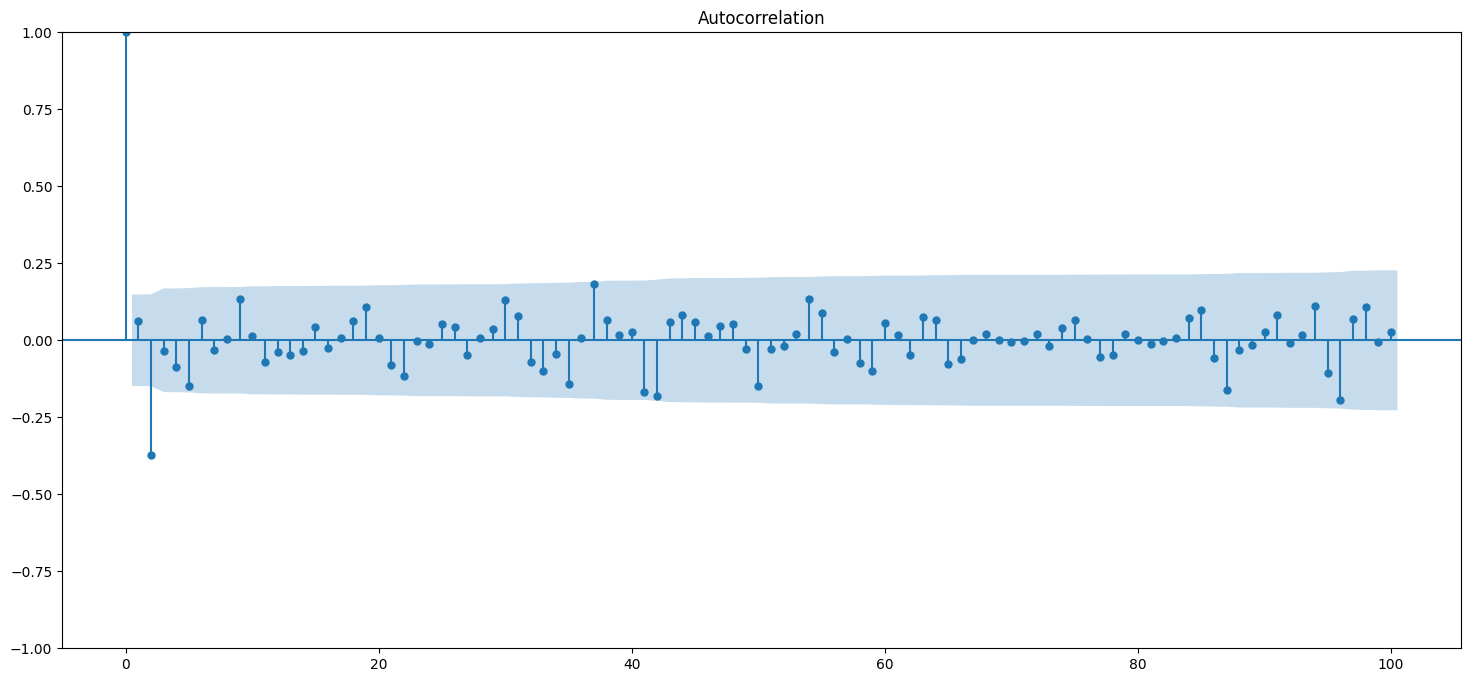

-------------Convulucion W1 1/6 


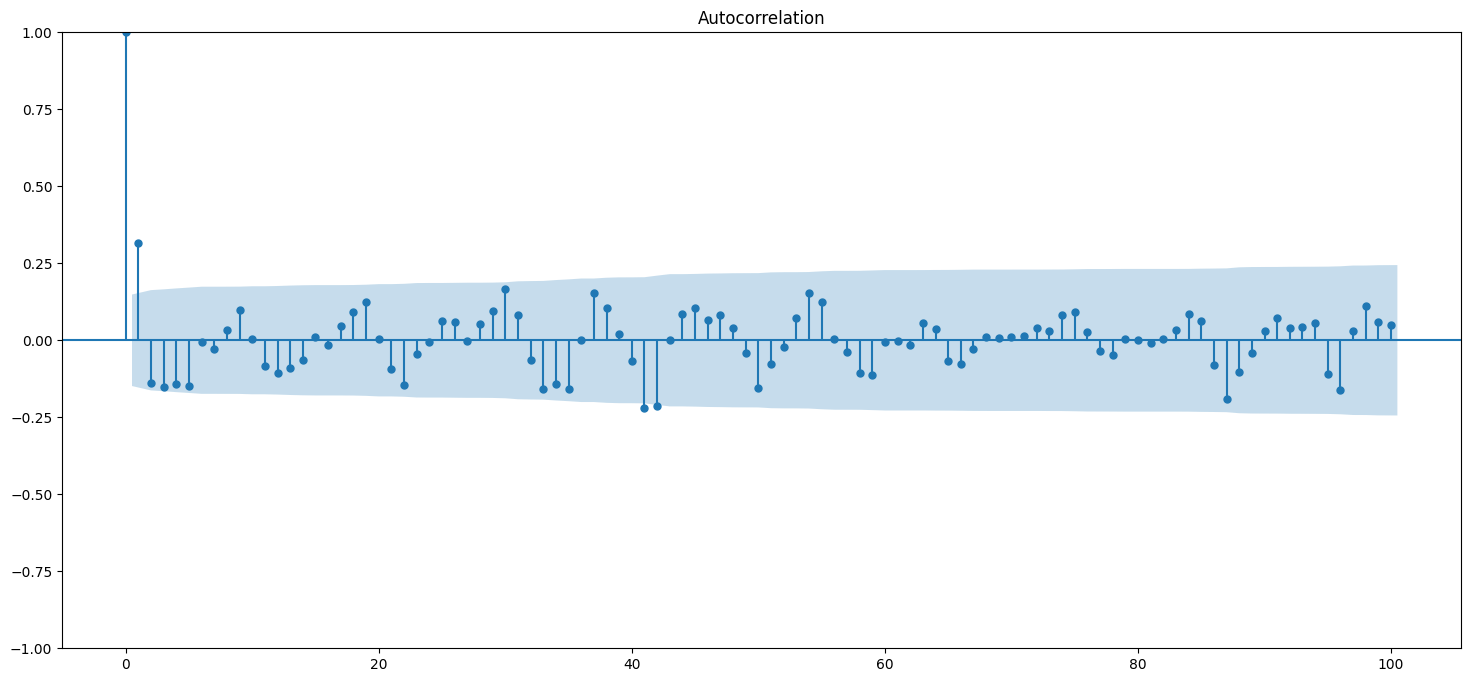

Para el modelo W2--------------------------------------------------------
-------------Convulucion W2 1/2 


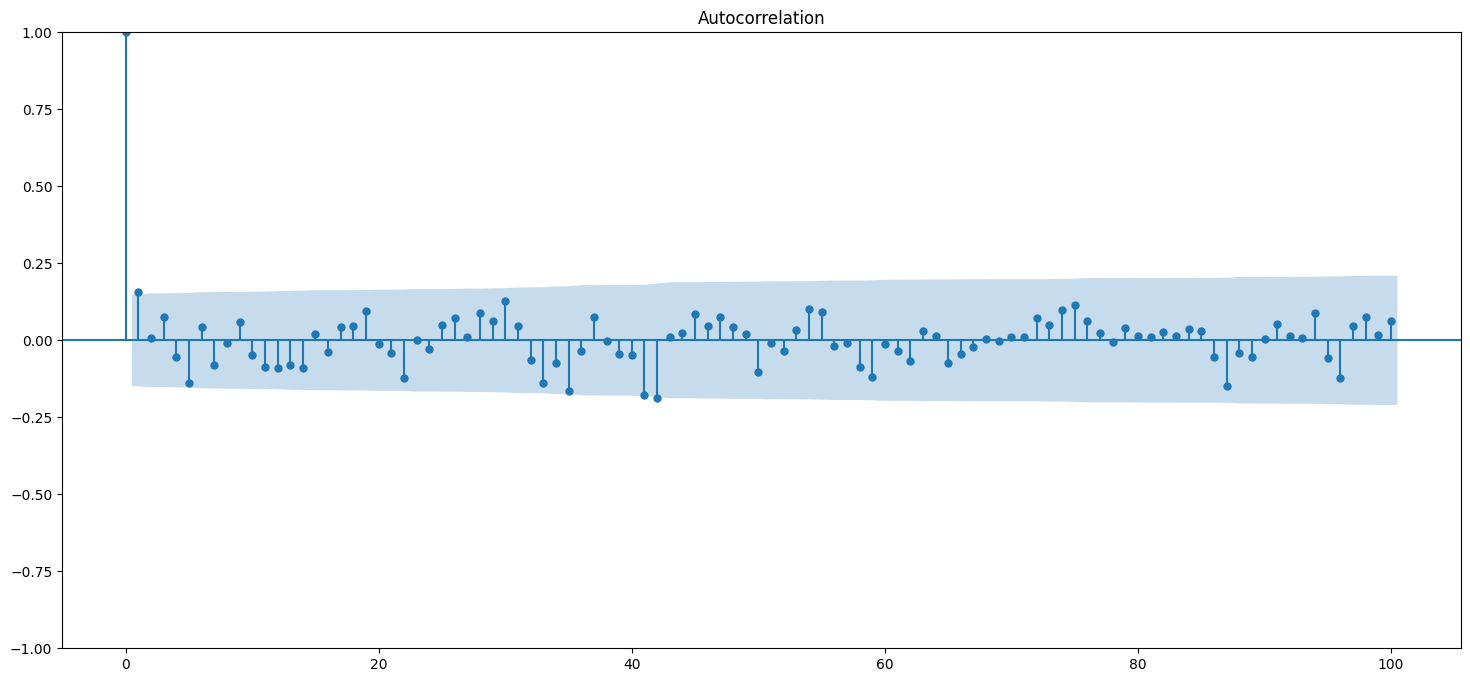

-------------Convulucion W2 1/3 


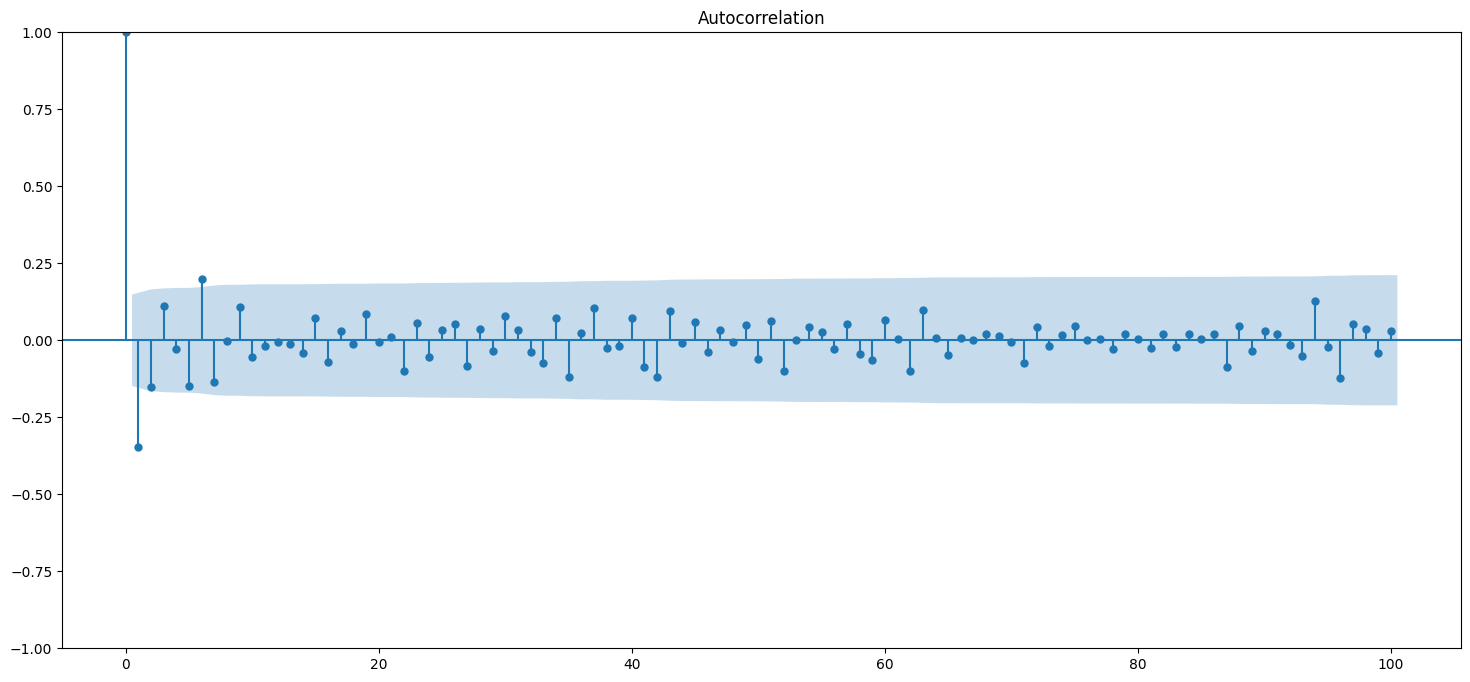

-------------Convulucion W2 1/4 


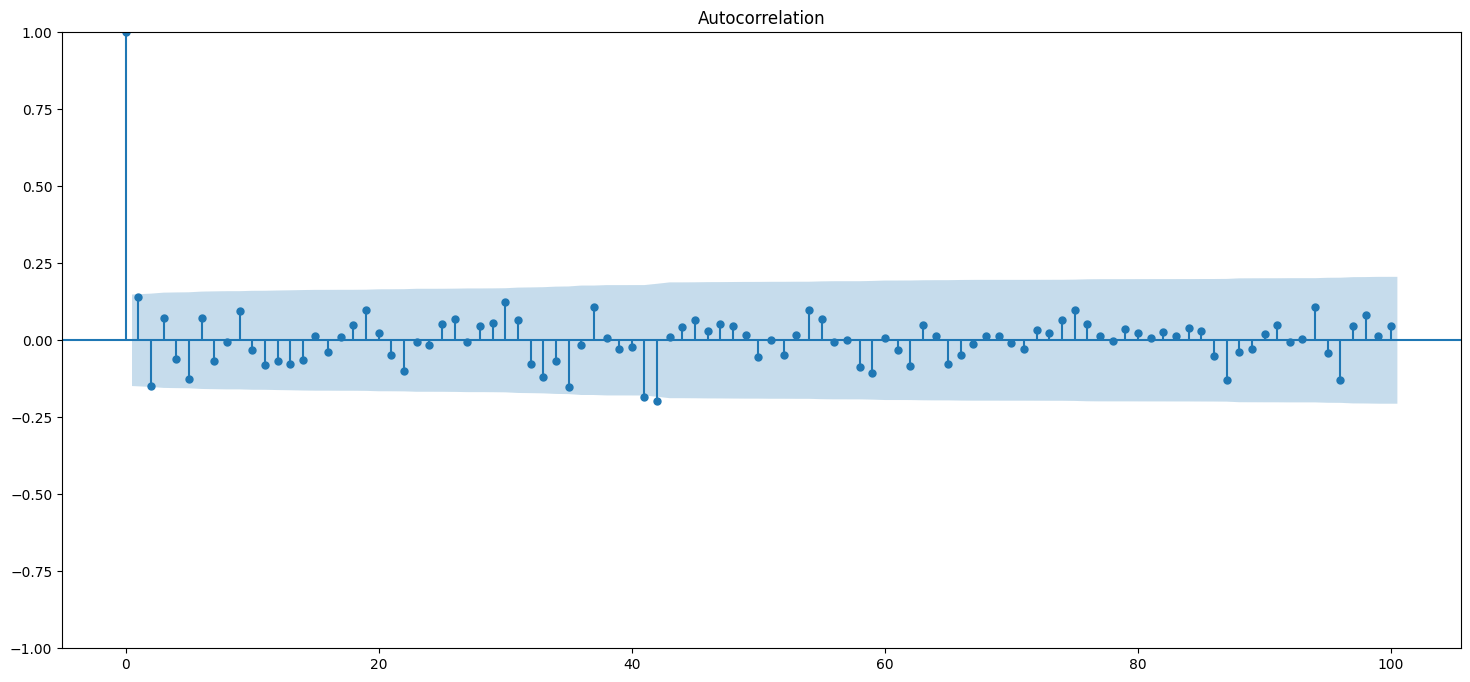

-------------Convulucion W2 1/5 


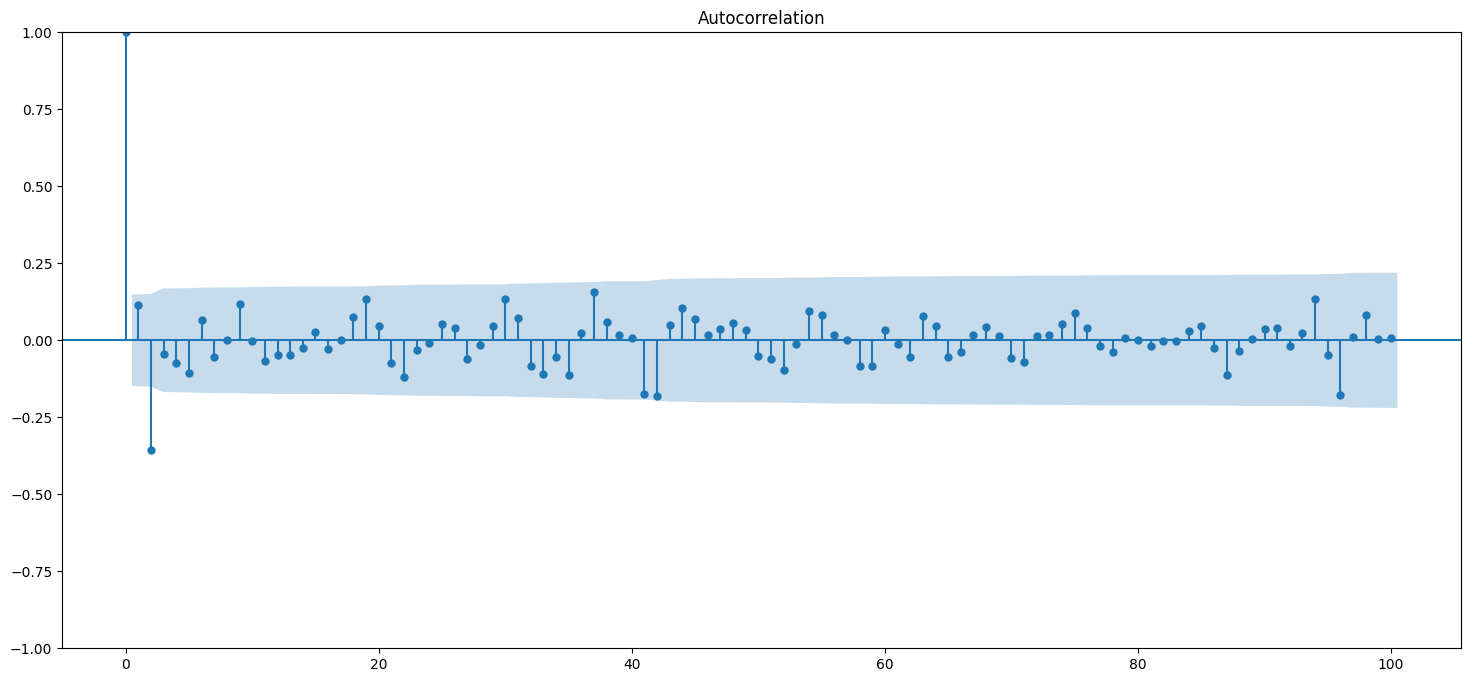

-------------Convulucion W2 1/6 


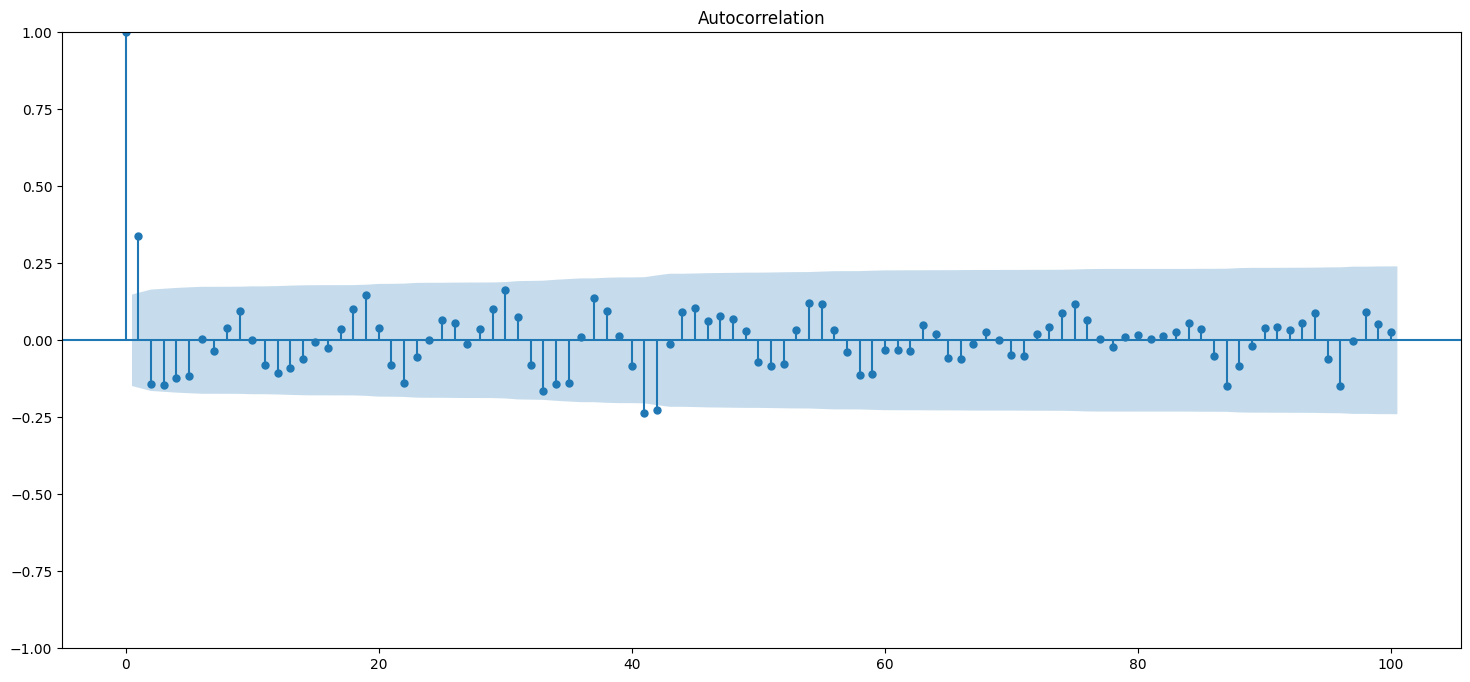

Para el modelo W3--------------------------------------------------------
-------------Convulucion W3 1/2 


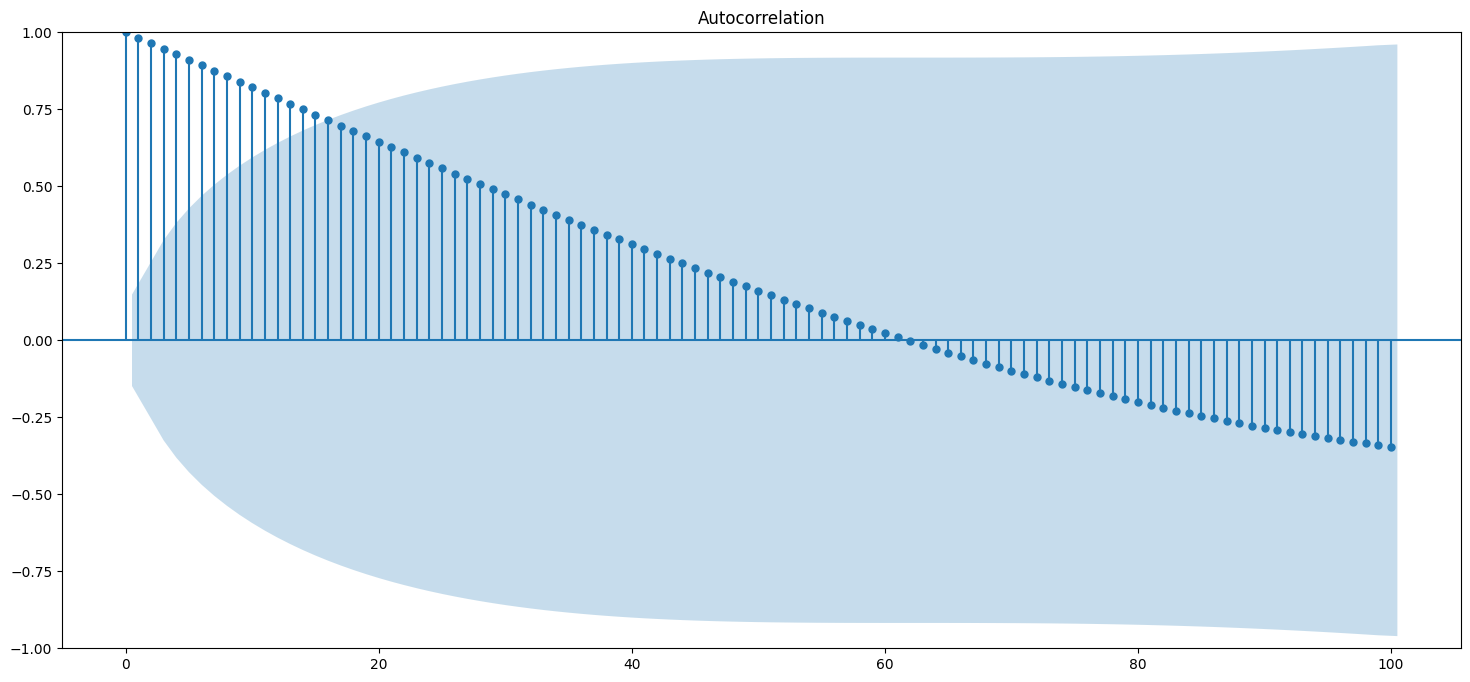

-------------Convulucion W3 1/3 


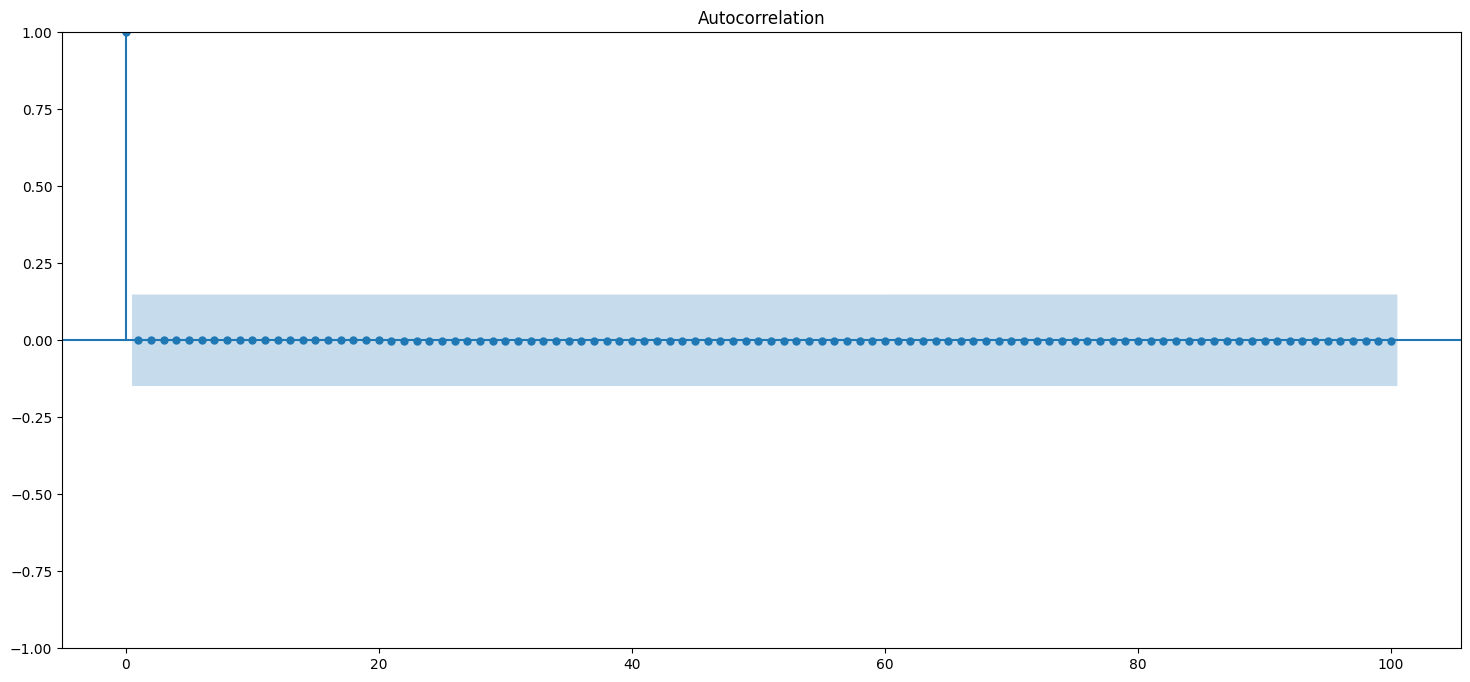

-------------Convulucion W3 1/4 


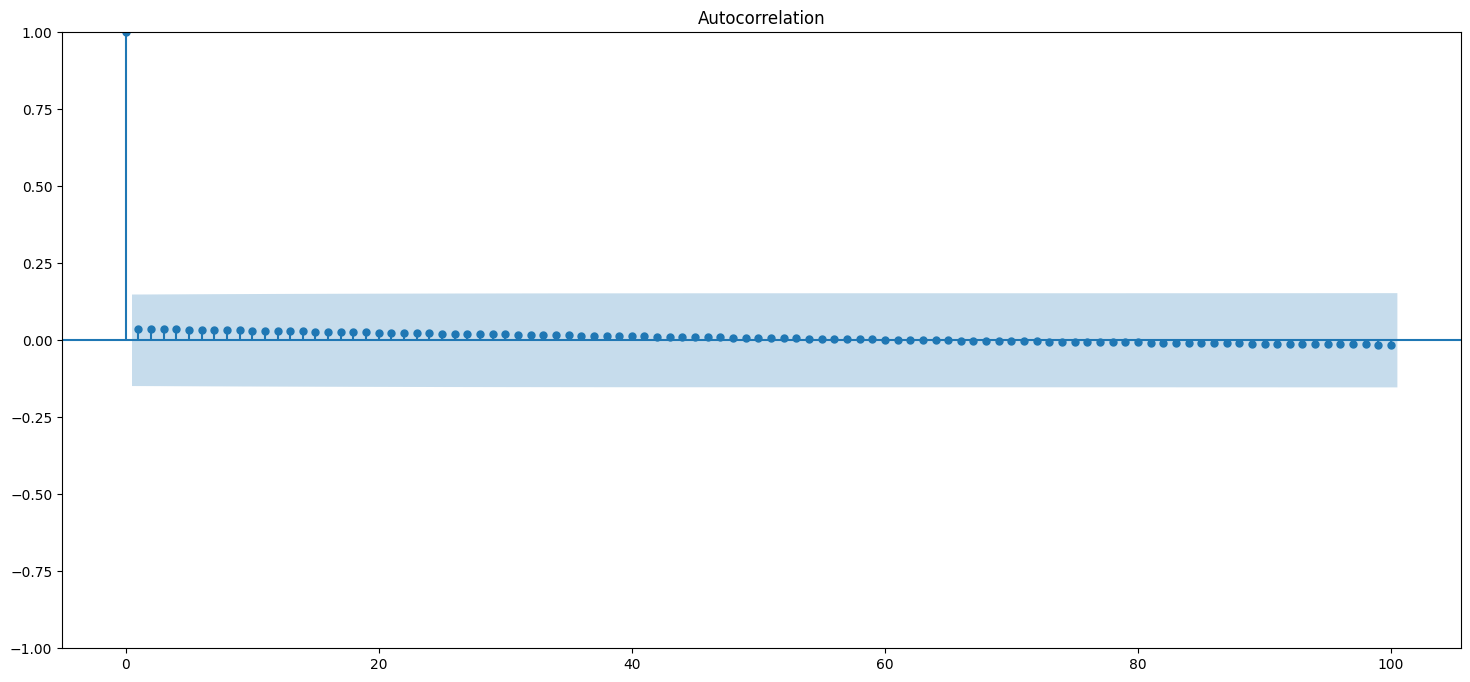

-------------Convulucion W3 1/5 


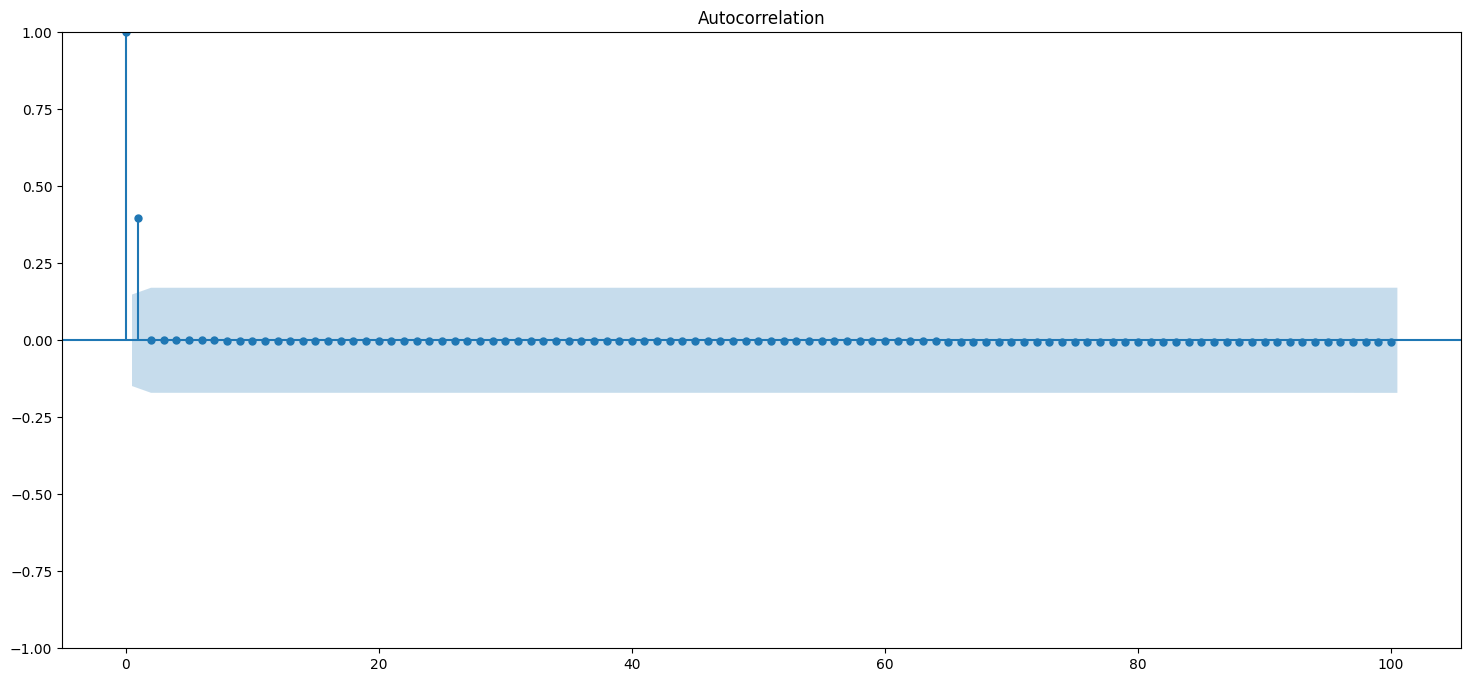

-------------Convulucion W3 1/6 


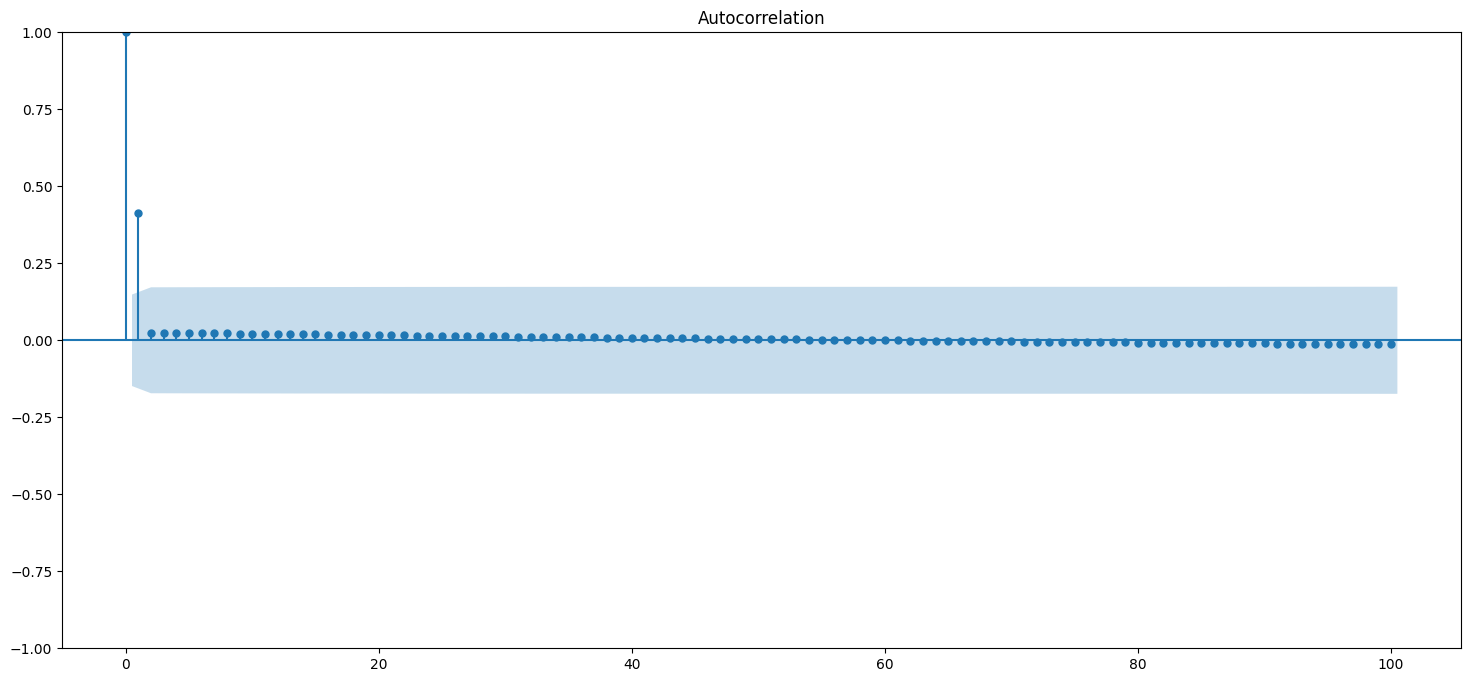

In [102]:
for j in range(1,4):
    print(f"Para el modelo W{j}--------------------------------------------------------")
    for i in range(2,7):
        coeffs = np.repeat(1/i, i)
        filtered_signal = convolve(df_filters["W"+str(j)], coeffs, mode='same')
        column_name= 'ConW'+str(j)+str(i)
        df_filters[column_name]=df_filters["W"+str(j)]-filtered_signal
        print(f"-------------Convulucion W{j} 1/{i} ")
        fig=plot_acf(df_filters[column_name], lags=100)
        fig.set_size_inches(18.05, 8)
        plt.show()

In [ ]:
for i in range(1,7):
    for j in range(3,7):
        coeffs = np.repeat(1/i, j)
        filtered_signal = convolve(df_filters["W1"], coeffs, mode='same')
        column_name= 'Con'+str(i)+str(j)
        df_filters[column_name]=df_filters["W1"]-filtered_signal
        print(f"Convulucion 1/{i} {j}")
        fig=plot_acf(df_filters[column_name], lags=100)
        fig.set_size_inches(18.05, 8)
        plt.show()

In [106]:
ls_best= ["ConW14","ConW24"]

In [107]:
df_best=df_filters[['AuxDate', 'W1','W2','W3']+ls_best ].copy()

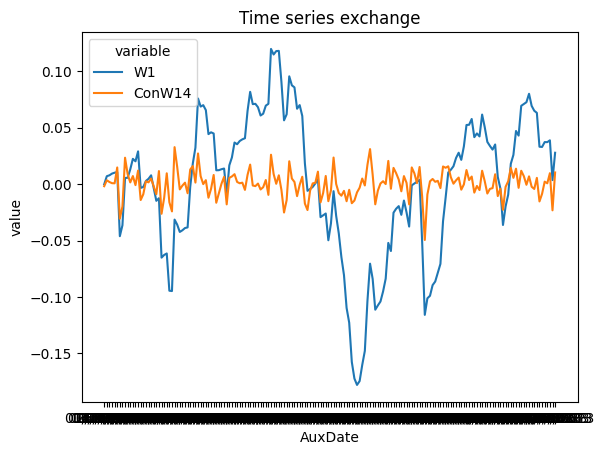

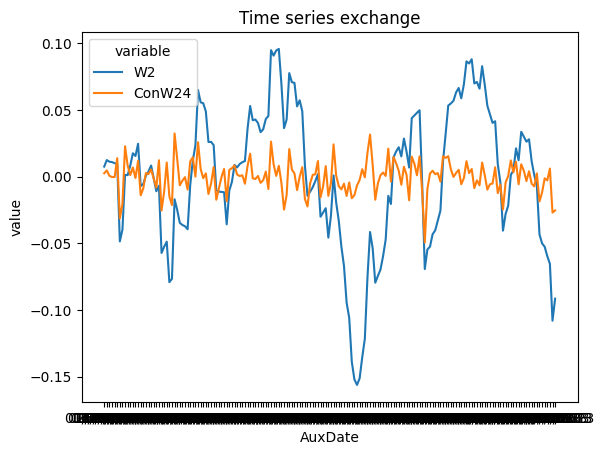

In [108]:
for model in ls_best: 
    g=sns.lineplot(x='AuxDate', y='value', hue='variable',data=pd.melt(df_best,id_vars=['AuxDate'],value_vars=["W"+model[4], model] ))
    g.set(title='Time series exchange')
    plt.show()

In [111]:
box_ljung(ls_best,df_filters)

,Model,lb_stat,lb_pvalue
0,ConW14,2.129828,0.144457
1,ConW14,5.581857,0.061364
2,ConW14,6.530211,0.088479
3,ConW14,7.161912,0.127575
4,ConW14,10.803543,0.055417
...,...,...,...
95,ConW24,63.783366,0.042232
96,ConW24,64.419601,0.046482
97,ConW24,64.940414,0.052014
98,ConW24,65.026274,0.062310
